<a href="https://colab.research.google.com/github/kidrono/PyTorch-FashionMNIST/blob/main/pytorch_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision with PyTorch

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

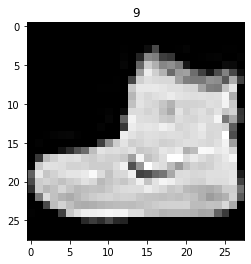

In [ ]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label=label)

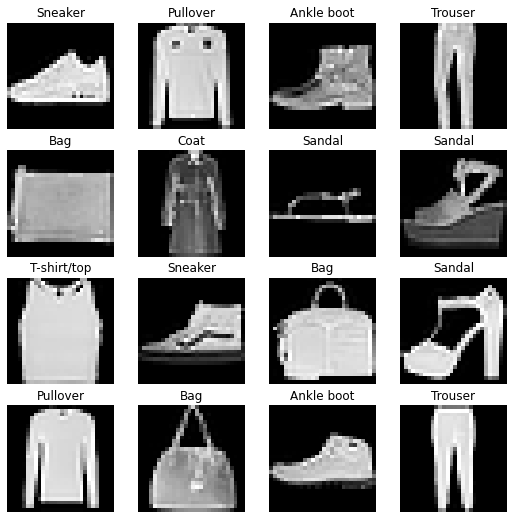

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
from torch.utils.data import DataLoader

BATCH = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH, shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f4a21e390d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f4a21e39100>)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

## Basline Model

In [ ]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x)

In [ ]:
class V0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(), 
                                     nn.Linear(in_features=input_shape,
                                               out_features=hidden_units),
                                     nn.Linear(in_features=hidden_units,
                                               out_features=output_shape))
    
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
model_0 = V0(784, 10, len(class_names))

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", 'wb') as f:
    f.write(request.content)

file already exists


In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as Timer

def print_time(start: float, end: float, device: torch.device = None):
  total = end - start
  print(f"running time is: {total}")
  return total

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
time_start_cpu = Timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samp;es")
    
  train_loss /= len(train_dataloader)

  test_loss = 0
  test_acc = 0

  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      t_loss = loss_fn(test_pred, y_test)
      test_loss += t_loss
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"train loss: {train_loss} | test_acc: {test_acc}")

time_end_cpu = Timer()
train_time = print_time(time_start_cpu, time_end_cpu)




  

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0 / 60000 samp;es
Looked at 12800 / 60000 samp;es
Looked at 25600 / 60000 samp;es
Looked at 38400 / 60000 samp;es
Looked at 51200 / 60000 samp;es
train loss: 0.5875949263572693 | test_acc: 82.25838658146965
Looked at 0 / 60000 samp;es
Looked at 12800 / 60000 samp;es
Looked at 25600 / 60000 samp;es
Looked at 38400 / 60000 samp;es
Looked at 51200 / 60000 samp;es
train loss: 0.47403019666671753 | test_acc: 81.68929712460064
Looked at 0 / 60000 samp;es
Looked at 12800 / 60000 samp;es
Looked at 25600 / 60000 samp;es
Looked at 38400 / 60000 samp;es
Looked at 51200 / 60000 samp;es
train loss: 0.45362597703933716 | test_acc: 82.93730031948881
running time is: 29.148889621999842


## setup device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Model 1 with non-linearity

In [ ]:
class V1(nn.Module):
  def __init__(self, input, hidden, output) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(nn.Flatten(), 
                                     nn.Linear(input, hidden),
                                     nn.ReLU(),
                                     nn.Linear(hidden, output),
                                     nn.ReLU())
    
  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)

model_1 = V1(784, 10, len(class_names)).to(device)

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [ ]:
def train_step(model, data_loader, loss_function, optim, 
               acc_fn, device: torch.device=device):
  train_loss = 0
  acc = 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    lss = loss_function(y_pred, y)
    train_loss += lss
    acc += acc_fn(y, y_pred.argmax(dim=1))
    optim.zero_grad()
    lss.backward()
    optim.step()

  train_loss /= len(data_loader)
  acc /= len(data_loader)
  print(f"train loss: {train_loss} | train accuracy: {acc}")

In [ ]:
def test_step(model, data_loader, loss_function, 
               acc_fn, device: torch.device=device):
  test_loss = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      t_loss = loss_function(test_pred, y_test)
      test_loss += t_loss
      test_acc += acc_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"test loss: {test_loss} | test_acc: {test_acc}") 

In [ ]:
torch.manual_seed(42)
start_time = Timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  train_step(model_1, train_dataloader, loss_fn, optimizer1, accuracy_fn,
             device)
  test_step(model_1, test_dataloader, loss_fn, accuracy_fn,
             device)

end_time = Timer()

final_time = print_time(start_time, end_time, device)

  0%|          | 0/3 [00:00<?, ?it/s]

train loss: 1.0919920206069946 | train accuracy: 61.343333333333334
test loss: 0.9569016695022583 | test_acc: 64.97603833865814
train loss: 0.7377949357032776 | train accuracy: 73.69333333333333
test loss: 0.7238789200782776 | test_acc: 74.21126198083067
train loss: 0.667761504650116 | train accuracy: 76.07666666666667
test loss: 0.6875133514404297 | test_acc: 75.63897763578275
running time is: 25.514725634000115


## Build CNN

In [ ]:
class V2(nn.Module):
  def __init__(self, input, hidden, output) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input, out_channels=hidden,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden, out_channels=hidden,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*7*7, out_features=output))
    
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [ ]:
torch.manual_seed(42)
model_2 = V2(1, 10, 10).to(device)
model_2

V2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
rand_image = torch.randn(size=(1, 28, 28))
pred = model_2(rand_image.unsqueeze(0).to(device))
pred

tensor([[-2.0928, -1.6365,  3.8742,  1.0352,  0.8338,  1.1799,  3.1342, -8.0339,
          2.7238, -2.0737]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
  print(epoch)
  train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)



  0%|          | 0/3 [00:00<?, ?it/s]

0
train loss: 0.3621334135532379 | train accuracy: 86.90666666666667
test loss: 0.34816035628318787 | test_acc: 87.52995207667732
1
train loss: 0.3227216303348541 | train accuracy: 88.34
test loss: 0.38567250967025757 | test_acc: 86.3817891373802
2
train loss: 0.300044983625412 | train accuracy: 89.25
test loss: 0.3358446955680847 | test_acc: 87.95926517571885


In [ ]:
from pathlib import Path

path = Path("models")
path.mkdir(parents=True, exist_ok=True)

model_name = "pytorch_03_model_2"
save_path = path / model_name

torch.save(obj=model_2.state_dict(), f=save_path)